<a href="https://colab.research.google.com/github/nawon0719/KU-NLP-Sentiment-Analysis/blob/main/English_Sentiment_Analysis_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#준비사항

In [ ]:
!pip install transformers
!pip install torch

분석 환경 셋팅

In [ ]:
import tensorflow as tf
import torch

import transformers
from transformers import ElectraTokenizer, ElectraModel, ElectraConfig, ElectraForSequenceClassification
from transformers import AdamW , get_linear_schedule_with_warmup
from transformers.modeling_tf_utils import get_initializer,keras_serializable, shape_list
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import files

import pandas as pd
import numpy as np
import random
import time
import datetime
import json


In [ ]:
#제이슨 타입 파일 처리용
def jsonToDf(file_name):
  with open(file_name, encoding = 'CP1252', mode = 'r') as file:
    json_array = json.load(file)
  
  result = pd.DataFrame.from_dict(json_array[0])

  is_first = True
  for array in json_array:
    if is_first:
      is_first = False
      continue
    
    temp_df = pd.DataFrame.from_dict(array)
    result = result.append(temp_df, ignore_index = True)

  return result

#Train set 로드
EmotionX push, train 데이터 추가 적용

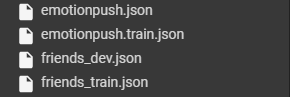

In [ ]:
train = jsonToDf('friends_train.json')
dev = jsonToDf('friends_dev.json')
train2=jsonToDf('emotionpush.json')
train3=jsonToDf('emotionpush.train.json')

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,Chandler,Youre a genius!,joy,0500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100


In [ ]:
print(train.shape)
print(dev.shape)
print(train2.shape)
print(train3.shape)
print(train2['emotion'].value_counts())


(10561, 4)
(1178, 4)
(14742, 4)
(10733, 4)
neutral        9855
joy            2100
non-neutral    1418
surprise        567
sadness         514
anger           140
disgust         106
fear             42
Name: emotion, dtype: int64


In [ ]:
#train, dev, train2, train3 데이터 합쳐서 새로운 트레인 데이터셋 구축
new_train=pd.concat([train, dev, train2, train3],ignore_index=True)
new_train=new_train.drop(columns=['speaker','annotation'])
new_train

,utterance,emotion
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
37209,It's Young Money,neutral
37210,Oh I was looking down near the 73s,surprise
37211,You're at 86,neutral
37212,Yea but idk if the 15% you get off for handing...,neutral


In [ ]:
new_train['emotion'].value_counts()

neutral        22246
joy             4988
non-neutral     4713
surprise        2373
sadness         1316
anger            832
disgust          454
fear             292
Name: emotion, dtype: int64

#전처리

##Spell Checker

실시간으로 spell checker실행하지 않고 교정완료 된 버전의 파일 불러와서 사용 가능

In [ ]:
!pip install tqdm
!pip install language-tool-python==2.4.7

In [ ]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US') 
from tqdm.notebook import tqdm 

In [ ]:
#Train 데이터 spell check
for i in tqdm(range(len(new_train))):
  try:
    test_data['utterance'][i] = tool.correct(test_data['utterance'][i])
  except:
    pass

In [ ]:
#데이터손실 방지 위해 csv저장
test_spell=new_train.to_csv('friends_train_spell_done.csv',encoding='utf-8', index=False)
from google.colab import files

files.download('friends_train_spell_done3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#검사완료한 버전 읽어오기
new_train = pd.read_csv("/content/friends_train_spell_done.csv", encoding='utf-8', sep=',')
new_train

,utterance,emotion
0,Also I was the point person on my company tran...,neutral
1,You must had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
37209,It's Young Money,neutral
37210,"Oh, I was looking down near the 73s",surprise
37211,You're at 86,neutral
37212,Yea but IDK if the 15% you get off for handing...,neutral


##Train/Validation set 구분

In [ ]:
new_train, new_val =train_test_split(new_train, test_size=0.2, random_state=2020, shuffle='TRUE')

In [ ]:
print(new_train['emotion'].value_counts())
print(new_val['emotion'].value_counts())

neutral        17726
joy             4035
non-neutral     3780
surprise        1927
sadness         1034
anger            660
disgust          375
fear             234
Name: emotion, dtype: int64
neutral        4520
joy             953
non-neutral     933
surprise        446
sadness         282
anger           172
disgust          79
fear             58
Name: emotion, dtype: int64


##불균형 데이터 조절
train data만 단순 반복을 통한 오버샘플링



In [ ]:
f=new_train[new_train['emotion']=='fear']
d=new_train[new_train['emotion']=='disgust']
a=new_train[new_train['emotion']=='anger']
sad=new_train[new_train['emotion']=='sadness']
sup=new_train[new_train['emotion']=='surprise']
joy=new_train[new_train['emotion']=='joy']
non=new_train[new_train['emotion']=='non-neutral']

In [ ]:
new_train=pd.concat([new_train,f,f,f,f,f,f,f],ignore_index=True)
new_train=pd.concat([new_train,d,d,d,d,d,d,d],ignore_index=True)
new_train=pd.concat([new_train,a,a,a,a,a],ignore_index=True)
new_train=pd.concat([new_train,sad,sad,sad,sad],ignore_index=True)
new_train=pd.concat([new_train,sup,sup,sup,sup,joy,joy,non,non],ignore_index=True)

print(new_train['emotion'].value_counts())
new_train.tail()

neutral        17726
joy            12105
non-neutral    11340
surprise        9635
sadness         5170
anger           3960
disgust         3000
fear            1872
Name: emotion, dtype: int64


,utterance,emotion
64803,Hey! How it goes?,non-neutral
64804,It actually says that,non-neutral
64805,See? IBM doing it. I am totally doing it. I l...,non-neutral
64806,Noon,non-neutral
64807,"Oh-ho yeah! A song with rhyming words. OO, I n...",non-neutral


In [ ]:
len(new_train)

64808

##데이터 인풋

In [ ]:
MAX_LEN = 128

def getInputsAndLabels(dataset):
  data = dataset.copy(deep=True)
  
  #문장추출
  utterances = data['utterance'] #train, val data
  utterances = ["[CLS] " + str(utterance) + " [SEP]" for utterance in utterances]
  
  #str타입 라벨 처리
  encoder = LabelEncoder()
  labels = data['emotion'].values
  encoder.fit(labels)
  labels = encoder.transform(labels)

  #ELECTRA Tokenizer
  tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator',do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  #토큰을 숫자 인덱스로 변환
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  #어텐션 마스크
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, labels, attention_masks

In [ ]:
#제출용 테스트에서 인풋가져오기
def getInputsFromTest(dataset):
  data = dataset.copy(deep=True)

  utterances = data['utterance']
  utterances = ["[CLS] " + str(utterance) + " [SEP]" for utterance in utterances]

  tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, attention_masks

In [ ]:
#제출용 테스트데이터 인덱스 
def getIndex(dataset):
  data = dataset.copy(deep = True)
  input_index = data.index.tolist()
  return torch.tensor(input_index)

In [ ]:
train_inputs, train_labels, train_masks = getInputsAndLabels(new_train) #새로운 데이터셋
val_inputs, val_labels, val_masks = getInputsAndLabels(new_val) # 20% 분리한 검증데이터

In [ ]:
# train, val 데이터 파이토치 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(val_inputs)
validation_labels = torch.tensor(val_labels)
validation_masks = torch.tensor(val_masks)	

In [ ]:
print(train_inputs[4])
print(train_masks[4])
print(train_labels[4])

tensor([  101,   100,  3398,  1010,  3856,  1037,  3124,  1010,  4261, 17134,
         2629,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# **모델 생성**

디바이스 설정

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
# ELECTRA 모델 생성 > bert로도 테스팅
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 8)
model.cuda()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8
                )

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# **학습**

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1211
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
#Training Section

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
### Validation Section ### 

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로직과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch   500  of  2,026.    Elapsed: 0:01:58.
  Batch 1,000  of  2,026.    Elapsed: 0:03:55.
  Batch 1,500  of  2,026.    Elapsed: 0:05:53.
  Batch 2,000  of  2,026.    Elapsed: 0:07:51.

  Average training loss: 1.2283
  Training epcoh took: 0:07:57

Running Validation...
  Accuracy: 0.60276
  Validation took: 0:00:15

======== Epoch 2 / 10 ========
Training...
  Batch   500  of  2,026.    Elapsed: 0:01:57.
  Batch 1,000  of  2,026.    Elapsed: 0:03:54.
  Batch 1,500  of  2,026.    Elapsed: 0:05:51.
  Batch 2,000  of  2,026.    Elapsed: 0:07:48.

  Average training loss: 0.6029
  Training epcoh took: 0:07:54

Running Validation...
  Accuracy: 0.67725
  Validation took: 0:00:15

======== Epoch 3 / 10 ========
Training...
  Batch   500  of  2,026.    Elapsed: 0:01:57.
  Batch 1,000  of  2,026.    Elapsed: 0:03:54.
  Batch 1,500  of  2,026.    Elapsed: 0:05:50.
  Batch 2,000  of  2,026.    Elapsed: 0:07:46.

  Average training loss: 0.4201
  T

#Test Set 평가
Spell check (test_data)

In [ ]:
test_data = pd.read_csv('en_data.csv', encoding = 'utf-8')
test_data.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


In [ ]:
#제출용 맞춤법검사
for i in tqdm(range(len(test_data))):
  try:
    test_data['utterance'][i] = tool.correct(test_data['utterance'][i])
  except:
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#데이터인풋
test_data_inputs, test_data_masks = getInputsFromTest(test_data) #제출용

In [ ]:
#제출용(test_data)
test_data_index = getIndex(test_data)
test_data_inputs = torch.tensor(test_data_inputs)
test_data_masks = torch.tensor(test_data_masks)

test_data_data = TensorDataset(test_data_index, test_data_inputs, test_data_masks)
test_data_sampler = RandomSampler(test_data_data)
test_data_dataloader = DataLoader(test_data_data, sampler=test_data_sampler, batch_size=1) #batch=1

In [ ]:
#제출용 LABELING
test_result = test_data.copy(deep = True)

encoder = LabelEncoder()
labels = new_train['emotion'].values
encoder.fit(labels)
labels = encoder.transform(labels)

test_result['predicted'] = 'default'

for step, batch in enumerate(test_data_dataloader): #제출용: test_data_dataloader
    batch = tuple(t.to(device) for t in batch)
    b_index, b_input_ids, b_input_mask = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    idx = b_index.item()
    test_result['predicted'][idx] = encoder.classes_[np.argmax(logits)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_result[test_result['predicted']=='joy']

,id,i_dialog,i_utterance,speaker,utterance,predicted
11,11,1,6,Chandler,If,joy
24,24,3,2,Chandler,One more score to go! You can do it!,joy
29,29,3,7,Ross,Phoebe!!,joy
43,43,5,4,Ross,"Yeah, you got it right? You got it right? You ...",joy
57,57,7,3,Rachel,Yeah!,joy
...,...,...,...,...,...,...
1587,1587,149,1,Joey,Hey!,joy
1591,1591,149,5,Joey,Nice!,joy
1604,1604,150,0,Phoebe,Hey!,joy
1607,1607,150,3,Monica,"Oh-ho, look what I got Julio.",joy


In [ ]:
test_result

,id,i_dialog,i_utterance,speaker,utterance,predicted
0,0,0,0,Phoebe,"Alright, shadow do with him?",neutral
1,1,0,1,Monica,Oh! You're awake!,surprise
2,2,0,2,Joey,Then you have to come clean with Ma! This is n...,anger
3,3,0,3,Mr. Tribbiani,"Yeah, but this is",neutral
4,4,0,4,Joey,I don't want to hear it! Now go to my room!,anger
...,...,...,...,...,...,...
1618,1618,150,14,Joey,New.,neutral
1619,1619,150,15,Lauren,"Hi, Kate!",joy
1620,1620,150,16,Kate,"Hi, Lauren.",neutral
1621,1621,150,17,Joey,"Hi, Lauren.",neutral


In [ ]:
print(test_result['predicted'].value_counts())

neutral        675
non-neutral    331
surprise       240
joy            236
anger           52
sadness         47
fear            23
disgust         19
Name: predicted, dtype: int64


In [ ]:
test_result = test_result.drop(columns = ['i_dialog','i_utterance','speaker','utterance'])
test_csv = test_result.to_csv('eng_result(1223).csv',encoding='utf-8', index=False)
#다운로드
files.download('eng_result(1223).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spell Checker : https://pypi.org/project/language-tool-python/

전체적인 모델링 코드 및 학습내용 참고 : 

1) https://mccormickml.com/2019/07/22/BERT-fine-tuning/

2) https://colab.research.google.com/drive/1tIf0Ugdqg4qT7gcxia3tL7und64Rv1dP